# Recurrent Neural Network (RNNs)

Recurrent neural netokors is a neural network used for processing a sequences of data,the output of each state depends on the previous computations.

**Input** : x(t) sequece of data (list of words, time series)

**Hidden** : h(t) hidden state at time t and acts as "memory" of the network. The hidden state is computed based on the current input and the previous hidden state h(t-1)
$$
h(t)=f (U \ x(t)+W \ h(t-1))
$$
The function f is a non-linear transformation like tanh, ReLU or a Sigmoid.

**Weights** :
* input to hidden $\rightarrow$ weight matrix U
* hidden to hidden  $\rightarrow$ weight matrix W
* hidden to output $\rightarrow$ weight matrix V

**Output** : o(t) is the output os the network (most probable next word, stock price prediction)

![Recurrent_neural_network_unfold](Recurrent_neural_network_unfold.svg.png)


The RNN forward pass can thus be represented by below set of equations.
$$a^{(t)} = b+ W \ h^{(t-1)} + U \ x^{(t)}$$
$$h^{(t)} = tanh(a^{(t)})$$
$$o^{(t)} = c+V \ h^{(t)}$$
$$\hat{y}^{(t)}=softmax(o^{(t)})$$

In [1]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt


from utils import ALL_LETTERS,N_LETTERS
from utils import load_data,letter_to_tensor,line_to_tensor,random_training_example

In [2]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.hidden_size=hidden_size
        self.i2h=nn.Linear(input_size+hidden_size,hidden_size)  #input to hidden
        self.i2o=nn.Linear(input_size+hidden_size,output_size)  #input to output
        self.softmax=nn.LogSoftmax(dim=1)
    

    def forward(self,input_tensor,hidden_tensor):
        combined=torch.cat((input_tensor,hidden_tensor),dim=1)

        hidden=self.i2h(combined)
        output=self.i2o(combined)

        output=self.softmax(output)

        return output,hidden

    def init_hidden(self):
        return torch.zeros(1,self.hidden_size)
    

In [3]:
category_lines,all_categories=load_data()
n_categories=len(all_categories)
#print(n_categories)

18


In [4]:
n_hidden=128
# the length of the input (one-hot vector) is equal to the number of letters
# the length of the hidden state is an hyperparameter
# the length of the output is the number of the categories
rnn=RNN(N_LETTERS,n_hidden,n_categories)

# one step (one character)
input_tensor=letter_to_tensor('A')
hidden_tensor=rnn.init_hidden()

output,next_hidden=rnn(input_tensor,hidden_tensor)

print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [7]:
def category_from_output(output):
    #return the category given the output of the softmax layer
    category_idx=torch.argmax(output).item()
    return all_categories[category_idx]

In [9]:
print(category_from_output(output))

Russian


4999 4.999 2.4955 Negrini / Polish WRONG (Italian)
9999 9.998999999999999 2.7428 Macon / Arabic WRONG (French)
14999 14.999 2.6766 Morehin / Irish WRONG (Russian)
19999 19.999 2.3103 Teasdale / French WRONG (English)
24999 24.999 2.7181 Maguire / Portuguese WRONG (Irish)
29999 29.999 2.7495 Yakubik / Polish WRONG (Russian)
34999 34.999 0.6600 Agnusdei / Italian CORRECT
39999 39.999 3.3565 Shichirobei / Polish WRONG (Japanese)
44999 44.999 1.2560 Armbruster / German CORRECT
49999 49.999 2.3265 Gerhardt / French WRONG (German)
54999 54.998999999999995 2.6050 Bordelon / English WRONG (French)
59999 59.999 0.2542 Kimura / Japanese CORRECT
64999 64.999 0.0352 Koustoubos / Greek CORRECT
69999 69.999 1.5656 Puga / Portuguese WRONG (Spanish)
74999 74.99900000000001 0.2205 Dam / Vietnamese CORRECT
79999 79.999 0.6292 Cai / Chinese CORRECT
84999 84.999 1.2696 Baba / Japanese WRONG (Arabic)
89999 89.999 1.9491 Kann / Chinese WRONG (Dutch)
94999 94.999 0.4230 Sook / Korean CORRECT
99999 99.9990000

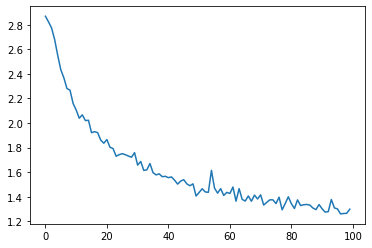

In [10]:
criterion=nn.NLLLoss()
lr=0.005
optimizer=torch.optim.SGD(rnn.parameters(),lr=lr)

def train(line_tensor,category_tensor):
    # initialize the hidden state
    hidden=rnn.init_hidden()

    # pass the whole sequence (word) in the RNN
    # line_tensor.size()[0] = length of the word
    for i in range(line_tensor.size()[0]): 
        output,hidden=rnn(line_tensor[i],hidden)
    
    loss=criterion(output,category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

current_loss=0
all_losses=[]
plot_steps,print_steps=1000,5000
n_iters=100000
for i in range(n_iters):
    category,line,category_tensor,line_tensor=random_training_example(category_lines,all_categories)
    
    output,loss=train(line_tensor,category_tensor)
    current_loss+=loss

    if (i+1)% plot_steps==0:
        all_losses.append(current_loss/plot_steps)
        current_loss=0
    if (i+1)% print_steps==0:
        guess=category_from_output(output)
        correct='CORRECT' if guess==category else f'WRONG ({category})'
        print(f'{i} {i/n_iters*100} {loss:.4f} {line} / {guess} {correct}')

plt.figure()
plt.plot(all_losses)
plt.show()


In [25]:
def predict(input_line):
    print(f'\n>{input_line}')
    with torch.no_grad():
        line_tensor=line_to_tensor(input_line)
        hidden=rnn.init_hidden()

        for i in range(line_tensor.size()[0]): 
            output,hidden=rnn(line_tensor[i],hidden)
        
        guess=category_from_output(output)
        print(guess)     

In [28]:
while True:
    sentence=input('input:')
    if sentence=='quit':
        break
    predict(sentence)


>Albero
Portuguese

>Albero
Portuguese
